In [1]:
#@title Colab setup: GPU check + installs + imports
!nvidia-smi -L || echo "No GPU detected (CPU-only runtime)."

# OpenCV + tqdm (PyTorch is usually preinstalled in Colab)
!pip install -q opencv-python tqdm

import os
import random
import hashlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


DATA_ZIP_URL = "https://datasets-cvlab.epfl.ch/2019-road-anomaly/RoadAnomaly_jpg.zip"
ZIP_NAME = "RoadAnomaly_jpg.zip"

if not os.path.exists(ZIP_NAME):
    !wget -q "{DATA_ZIP_URL}" -O "{ZIP_NAME}"
    print("Downloaded:", ZIP_NAME)
else:
    print("Zip file already exists, skipping download.")

!unzip -q -o "{ZIP_NAME}" -d .


# Dataset root (folder name after you upload/unzip RoadAnomaly_jpg)
DATASET_ROOT = "RoadAnomaly_jpg"

# If you upload a zip named RoadAnomaly_jpg.zip, auto-unzip it
zip_path = "RoadAnomaly_jpg.zip"
if (not os.path.isdir(DATASET_ROOT)) and os.path.isfile(zip_path):
    import zipfile
    print(f"Found {zip_path}, extracting to /content ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall("/")
    print("✅ Extraction done.")

@dataclass
class Config:
    dataset_root: str = DATASET_ROOT
    image_size: int = 512
    train_fraction: float = 0.8
    batch_size: int = 4
    num_workers: int = 2
    num_epochs: int = 50          # bump this later if you want
    lr: float = 1e-4
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()
print(cfg)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)
print(f"Using device: {cfg.device}")


GPU 0: NVIDIA GeForce RTX 4090 (UUID: GPU-14d0ba8a-c20d-2b7a-0816-487286101197)
Zip file already exists, skipping download.
Config(dataset_root='RoadAnomaly_jpg', image_size=512, train_fraction=0.8, batch_size=4, num_workers=2, num_epochs=5, lr=0.0001, seed=42, device='cuda')
Using device: cuda


In [2]:
#@title Dataset helpers: scan images, create split, make dark images, build loaders

def get_frames_dir(cfg):
    frames_dir = os.path.join(cfg.dataset_root, "frames")
    if not os.path.isdir(frames_dir):
        print(f"❗ frames/ directory not found under {cfg.dataset_root}")
        print("   Make sure you uploaded/unzipped RoadAnomaly_jpg so that:")
        print("   RoadAnomaly_jpg/frames/ contains the .jpg files.")
        return None
    return frames_dir

def list_bright_images(cfg):
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        return []
    bright_paths = sorted(str(p) for p in Path(frames_dir).glob("*.jpg"))
    if not bright_paths:
        print(f"❗ No .jpg images found in {frames_dir}")
    else:
        print(f"✅ Found {len(bright_paths)} bright images in {frames_dir}")
    return bright_paths

def create_or_load_split(cfg, bright_paths):
    n = len(bright_paths)
    if n == 0:
        return None, None
    split_file = os.path.join(cfg.dataset_root, "split_indices.npz")
    if os.path.isfile(split_file):
        data = np.load(split_file, allow_pickle=True)
        train_idx = data["train_idx"]
        val_idx = data["val_idx"]
        print(f"🔁 Loaded split from {split_file} "
              f"(train={len(train_idx)}, val={len(val_idx)})")
    else:
        rng = np.random.RandomState(cfg.seed)
        indices = np.arange(n)
        rng.shuffle(indices)
        split_point = int(n * cfg.train_fraction)
        train_idx = indices[:split_point]
        val_idx = indices[split_point:]
        np.savez(split_file, train_idx=train_idx, val_idx=val_idx)
        print(f"✂️ Created new split and saved to {split_file} "
              f"(train={len(train_idx)}, val={len(val_idx)})")
    return train_idx, val_idx

def compute_image_seed(path: str, global_seed: int = 42) -> int:
    """Deterministic per-image seed from filename + global seed."""
    base = os.path.basename(path)
    h = hashlib.md5(base.encode("utf-8")).hexdigest()
    name_int = int(h[:8], 16) & 0xFFFFFFFF
    return (name_int ^ global_seed) & 0xFFFFFFFF

def darken_image_array(img_rgb: np.ndarray,
                       rng: np.random.RandomState,
                       gamma_range=(2.0, 4.0),
                       noise_std_range=(0.0, 0.05)) -> np.ndarray:
    """Apply gamma darkening + Gaussian noise in a reproducible way."""
    img = img_rgb.astype(np.float32) / 255.0
    gamma = rng.uniform(*gamma_range)
    noise_std = rng.uniform(*noise_std_range)
    dark = np.clip(img ** gamma, 0.0, 1.0)
    noise = rng.normal(0.0, noise_std, size=dark.shape).astype(np.float32)
    dark = np.clip(dark + noise, 0.0, 1.0)
    return (dark * 255.0).astype(np.uint8)

def ensure_dark_images(cfg, bright_paths):
    """
    For each bright frame, create a dark counterpart in frames_dark/
    using deterministic gamma & noise based on filename and cfg.seed.
    """
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    os.makedirs(dark_dir, exist_ok=True)
    created = 0
    for bright_path in bright_paths:
        name = os.path.basename(bright_path)
        dark_path = os.path.join(dark_dir, name)
        if os.path.isfile(dark_path):
            continue
        bgr = cv2.imread(bright_path, cv2.IMREAD_COLOR)
        if bgr is None:
            print(f"⚠️ Could not read {bright_path}, skipping.")
            continue
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        seed = compute_image_seed(bright_path, cfg.seed)
        rng = np.random.RandomState(seed)
        dark_rgb = darken_image_array(rgb, rng)
        dark_bgr = cv2.cvtColor(dark_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite(dark_path, dark_bgr)
        created += 1
    print(f"✅ Dark images ready in {dark_dir}. Newly created: {created}")
    return dark_dir

def load_and_preprocess(path: str, image_size: int) -> np.ndarray:
    """
    Load path → RGB → resize so max(h,w)=image_size → pad to square → [0,1] float.
    """
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise RuntimeError(f"Could not read image: {path}")
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    scale = image_size / max(h, w)
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    rgb_resized = cv2.resize(rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)
    top = (image_size - new_h) // 2
    bottom = image_size - new_h - top
    left = (image_size - new_w) // 2
    right = image_size - new_w - left
    rgb_padded = cv2.copyMakeBorder(
        rgb_resized, top, bottom, left, right, borderType=cv2.BORDER_REFLECT
    )
    img = rgb_padded.astype(np.float32) / 255.0  # H,W,3 in [0,1]
    return img

class RoadAnomalyPairs(Dataset):
    """
    Dataset of (dark, bright) image pairs using RoadAnomaly frames and
    precomputed frames_dark.
    """
    def __init__(self, cfg, bright_paths, indices):
        self.cfg = cfg
        self.bright_paths = bright_paths
        self.indices = [int(i) for i in indices]
        self.dark_dir = os.path.join(cfg.dataset_root, "frames_dark")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        bright_path = self.bright_paths[real_idx]
        name = os.path.basename(bright_path)
        dark_path = os.path.join(self.dark_dir, name)

        bright = load_and_preprocess(bright_path, self.cfg.image_size)
        dark   = load_and_preprocess(dark_path,   self.cfg.image_size)

        bright_t = torch.from_numpy(bright).permute(2, 0, 1)  # C,H,W
        dark_t   = torch.from_numpy(dark).permute(2, 0, 1)

        return {
            "dark": dark_t,
            "bright": bright_t,
            "path": bright_path,
        }

def create_dataloaders(cfg):
    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        print("⛔ No bright images available. Upload/unzip RoadAnomaly_jpg and rerun this cell.")
        return None, None, bright_paths, (None, None)

    train_idx, val_idx = create_or_load_split(cfg, bright_paths)
    if train_idx is None:
        return None, None, bright_paths, (None, None)

    ensure_dark_images(cfg, bright_paths)

    train_ds = RoadAnomalyPairs(cfg, bright_paths, train_idx)
    val_ds   = RoadAnomalyPairs(cfg, bright_paths, val_idx)

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    return train_loader, val_loader, bright_paths, (train_idx, val_idx)

print("✅ Dataset helpers ready.")


✅ Dataset helpers ready.


In [3]:
#@title UNet model definition (dark → bright)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch * 2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(base_ch * 4, base_ch * 8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(base_ch * 8, base_ch * 16)

        self.up4 = nn.ConvTranspose2d(base_ch * 16, base_ch * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(base_ch * 16, base_ch * 8)
        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch * 8, base_ch * 4)
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)
        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, out_ch, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)
        e4 = self.enc4(p3); p4 = self.pool4(e4)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))
        u3 = self.up3(d4)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))
        u2 = self.up2(d3)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        out = torch.sigmoid(self.out_conv(d1))
        return out

print("✅ UNet model defined.")


✅ UNet model defined.


✅ Found 60 bright images in RoadAnomaly_jpg/frames
🔁 Loaded split from RoadAnomaly_jpg/split_indices.npz (train=42, val=9)
✅ Dark images ready in RoadAnomaly_jpg/frames_dark. Newly created: 0
Train batches: 11, Val batches: 3


Epoch 1/5 [train]: 100%|██████████████████████████████| 11/11 [00:01<00:00,  9.93it/s]


Epoch 1: train L1 = 0.1726


Epoch 1/5 [val]: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 19.11it/s]


Epoch 1: val L1 = 0.2258
🌟 New best model with val L1 = 0.2258


Epoch 2/5 [train]: 100%|██████████████████████████████| 11/11 [00:00<00:00, 15.57it/s]


Epoch 2: train L1 = 0.1219


Epoch 2/5 [val]: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 22.11it/s]


Epoch 2: val L1 = 0.2130
🌟 New best model with val L1 = 0.2130


Epoch 3/5 [train]: 100%|██████████████████████████████| 11/11 [00:00<00:00, 15.41it/s]


Epoch 3: train L1 = 0.1011


Epoch 3/5 [val]: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 22.19it/s]


Epoch 3: val L1 = 0.1805
🌟 New best model with val L1 = 0.1805


Epoch 4/5 [train]: 100%|██████████████████████████████| 11/11 [00:00<00:00, 15.30it/s]


Epoch 4: train L1 = 0.0894


Epoch 4/5 [val]: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 21.26it/s]


Epoch 4: val L1 = 0.1426
🌟 New best model with val L1 = 0.1426


Epoch 5/5 [train]: 100%|██████████████████████████████| 11/11 [00:00<00:00, 15.45it/s]


Epoch 5: train L1 = 0.0863


Epoch 5/5 [val]: 100%|██████████████████████████████████| 3/3 [00:00<00:00, 21.84it/s]


Epoch 5: val L1 = 0.1021
🌟 New best model with val L1 = 0.1021
💾 Saved best model to RoadAnomaly_jpg/checkpoints/unet_dark_to_bright.pth
✅ Found 60 bright images in RoadAnomaly_jpg/frames


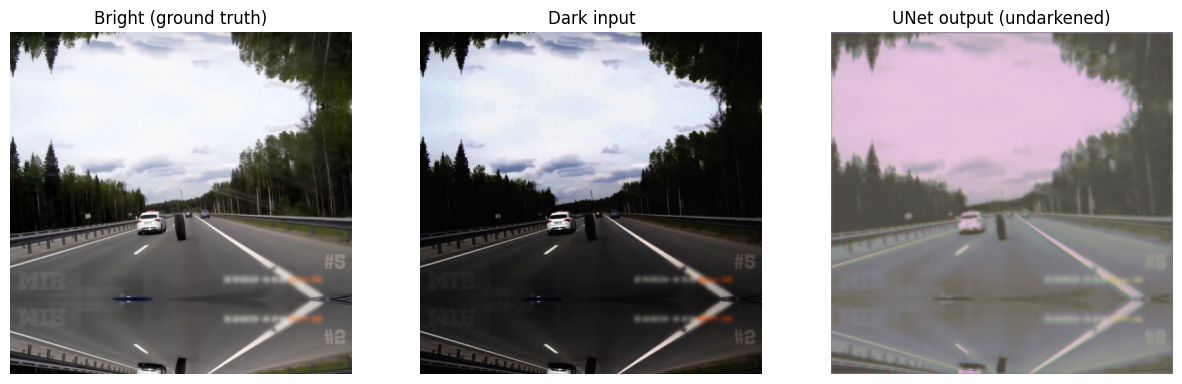

Example: RoadAnomaly_jpg/frames/lost_tires08.jpg


In [4]:
#@title Train UNet and visualize an example

def train_unet(cfg):
    train_loader, val_loader, bright_paths, _ = create_dataloaders(cfg)
    if train_loader is None:
        print("Training aborted: dataloaders not ready.")
        return None

    device = cfg.device
    model = UNet(in_ch=3, out_ch=3, base_ch=32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr)
    criterion = nn.L1Loss()

    best_val_loss = float("inf")
    best_state = None

    for epoch in range(cfg.num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [train]"):
            dark = batch["dark"].to(device)
            bright = batch["bright"].to(device)

            optimizer.zero_grad()
            pred = model(dark)
            loss = criterion(pred, bright)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * dark.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}: train L1 = {train_loss:.4f}")

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs} [val]"):
                dark = batch["dark"].to(device)
                bright = batch["bright"].to(device)
                pred = model(dark)
                loss = criterion(pred, bright)
                val_running += loss.item() * dark.size(0)
        val_loss = val_running / len(val_loader.dataset)
        print(f"Epoch {epoch+1}: val L1 = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict().copy()
            print(f"🌟 New best model with val L1 = {best_val_loss:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    ckpt_dir = os.path.join(cfg.dataset_root, "checkpoints")
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, "unet_dark_to_bright.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved best model to {ckpt_path}")
    return model

def visualize_example(model, cfg):
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        print("Dataset not ready, cannot visualize.")
        return

    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        return

    import random as _random
    bright_path = _random.choice(bright_paths)
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    dark_path = os.path.join(dark_dir, os.path.basename(bright_path))

    bright = load_and_preprocess(bright_path, cfg.image_size)
    dark = load_and_preprocess(dark_path, cfg.image_size)

    dark_t = torch.from_numpy(dark).permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    model.eval()
    with torch.no_grad():
        pred_t = model(dark_t)
    pred = pred_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(bright)
    axes[0].set_title("Bright (ground truth)")
    axes[0].axis("off")
    axes[1].imshow(dark)
    axes[1].set_title("Dark input")
    axes[1].axis("off")
    axes[2].imshow(pred)
    axes[2].set_title("UNet output (undarkened)")
    axes[2].axis("off")
    plt.show()
    print("Example:", bright_path)

# ---- Run training and show result ----

model = train_unet(cfg)
if model is not None:
    visualize_example(model, cfg)


✅ Found 60 bright images in RoadAnomaly_jpg/frames


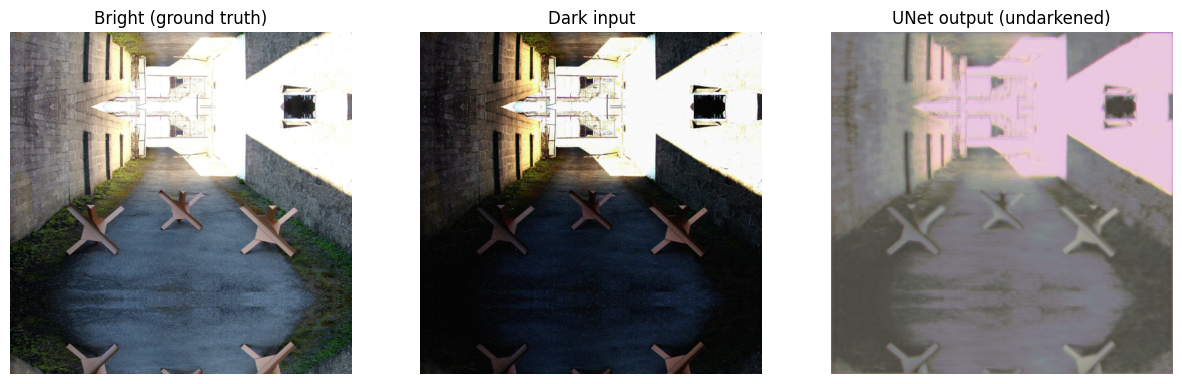

Example: RoadAnomaly_jpg/frames/obstacles06_cardboard_czech_hedgehog.jpg


In [11]:
# cfg.num_epochs = 30;
# model = train_unet(cfg)
if model is not None:
    visualize_example(model, cfg)


In [6]:
%pip install pickleshare


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
#@title Clone DeepLabV3+ Cityscapes repo and download weights
import os
from pathlib import Path

REPO_ROOT = Path("DeepLabV3Plus-Pytorch")

if not REPO_ROOT.exists():
    # Clone the repository only once
    !git clone https://github.com/VainF/DeepLabV3Plus-Pytorch.git DeepLabV3Plus-Pytorch
else:
    print("Repo already exists at", REPO_ROOT)

# Install requirements (PyTorch is already available in Colab)
%cd DeepLabV3Plus-Pytorch
!pip install -r requirements.txt

# Ensure checkpoint directory and download Cityscapes model if missing
from pathlib import Path as _Path
CKPT_DIR = _Path("checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_PATH = CKPT_DIR / "best_deeplabv3plus_mobilenet_cityscapes_os16.pth"

# Official Cityscapes checkpoint URL from the DeepLabV3Plus-Pytorch repo
CKPT_URL = "https://www.dropbox.com/scl/fi/jo4nhw3h6lcg8t2ckarae/best_deeplabv3plus_mobilenet_cityscapes_os16.pth?rlkey=7qnzapkshyofrgfa1ls7vot6j&dl=1"

import subprocess as _subprocess, os as _os

def _download_ckpt(url: str, out_path: _Path) -> None:
    # Use -L to follow redirects and write atomically via temp file
    tmp_path = out_path.with_suffix(out_path.suffix + ".part")
    if tmp_path.exists():
        tmp_path.unlink()
    _subprocess.run(["wget", "-q", "-L", "-O", str(tmp_path), url], check=True)
    # Basic integrity check: file should be > 5MB
    if tmp_path.exists() and tmp_path.stat().st_size > 5_000_000:
        tmp_path.replace(out_path)
        print("Download complete:", out_path)
    else:
        # Cleanup bad file
        if tmp_path.exists():
            tmp_path.unlink()
        raise RuntimeError("Downloaded checkpoint appears invalid or too small (<5MB).")

if not CKPT_PATH.exists():
    print("Downloading Cityscapes pretrained checkpoint...")
    _download_ckpt(CKPT_URL, CKPT_PATH)
else:
    # If file exists but is suspiciously small, re-download
    if CKPT_PATH.stat().st_size <= 5_000_000:
        print("Existing checkpoint seems corrupted (too small). Re-downloading...")
        _download_ckpt(CKPT_URL, CKPT_PATH)
    else:
        print("Checkpoint already exists:", CKPT_PATH, f"size={CKPT_PATH.stat().st_size/1e6:.1f}MB")

# Go back to default working directory
%cd ..


Repo already exists at DeepLabV3Plus-Pytorch
/home/syed/ACV-HitMyCarInDark/DeepLabV3Plus-Pytorch
Checkpoint already exists: checkpoints/best_deeplabv3plus_mobilenet_cityscapes_os16.pth size=42.1MB
/home/syed/ACV-HitMyCarInDark


In [15]:
#@title Cityscapes anomaly model + utilities (DeepLabV3+ on UNet output)
import os
import sys
from pathlib import Path

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp

# Add DeepLabV3Plus repo to path with highest priority,
# so we definitely import its local `network` package,
# not the unrelated `network` package from pip.
REPO_ROOT = Path("DeepLabV3Plus-Pytorch")
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import network as deeplab_network  # local repo module

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 19
MODEL_NAME = "deeplabv3plus_mobilenet"
CKPT_FILENAME = "best_deeplabv3plus_mobilenet_cityscapes_os16.pth"
CKPT_PRIMARY = REPO_ROOT / "checkpoints" / CKPT_FILENAME
CKPT_FALLBACK = Path("checkpoints") / CKPT_FILENAME  # top-level fallback
CKPT_URLS = [
    # Primary Dropbox URL (redirects handled by -L when wget is used)
    "https://www.dropbox.com/scl/fi/jo4nhw3h6lcg8t2ckarae/best_deeplabv3plus_mobilenet_cityscapes_os16.pth?rlkey=7qnzapkshyofrgfa1ls7vot6j&dl=1",
]

MIN_VALID_BYTES = 5_000_000  # quick integrity threshold

def _is_valid_ckpt(path: Path) -> bool:
    try:
        return path.exists() and path.stat().st_size > MIN_VALID_BYTES
    except Exception:
        return False

def _attempt_download(out_path: Path) -> bool:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    tmp = out_path.with_suffix(out_path.suffix + ".part")
    if tmp.exists():
        tmp.unlink()
    for url in CKPT_URLS:
        try:
            sp.run(["wget", "-q", "-L", "-O", str(tmp), url], check=True)
            if _is_valid_ckpt(tmp):
                tmp.replace(out_path)
                print(f"Downloaded checkpoint to {out_path}")
                return True
            else:
                if tmp.exists():
                    tmp.unlink()
        except Exception as e:
            print(f"Download attempt failed from {url}: {e}")
            if tmp.exists():
                tmp.unlink()
    return False

def _safe_load_checkpoint(path: Path):
    """Load Cityscapes checkpoint robustly across PyTorch>=2.6.
    Tries weights_only=True with safe globals allowlist,
    and falls back to weights_only=False for trusted sources.
    If load fails due to corruption, tries fallback copy or re-downloads.
    """
    # First, ensure we have a valid candidate path
    candidate_paths = [path]
    if path != CKPT_FALLBACK:
        candidate_paths.append(CKPT_FALLBACK)

    last_err = None
    for p in candidate_paths:
        if not _is_valid_ckpt(p):
            continue
        try:
            torch.serialization.add_safe_globals([np.core.multiarray.scalar])
            return torch.load(str(p), map_location=DEVICE, weights_only=True)
        except Exception as e1:
            last_err = e1
            try:
                return torch.load(str(p), map_location=DEVICE, weights_only=False)
            except Exception as e2:
                last_err = e2
                print(f"Load failed from {p}: {e2}")

    # If we reach here, try re-download to primary path
    print("Checkpoint seems missing or corrupted; attempting re-download...")
    if _attempt_download(CKPT_PRIMARY):
        try:
            torch.serialization.add_safe_globals([np.core.multiarray.scalar])
            return torch.load(str(CKPT_PRIMARY), map_location=DEVICE, weights_only=True)
        except Exception:
            return torch.load(str(CKPT_PRIMARY), map_location=DEVICE, weights_only=False)

    # If still failing, raise the last encountered error
    raise RuntimeError(f"Failed to load Cityscapes checkpoint. Last error: {last_err}")

def load_cityscapes_model():
    """Load pretrained DeepLabV3+ on Cityscapes.
    Handles PyTorch 2.6's weights_only change, numpy scalar allowlist,
    and auto-recovers corrupted/missing checkpoints.
    """
    print("Loading Cityscapes model:", MODEL_NAME)
    model = deeplab_network.modeling.__dict__[MODEL_NAME](
        num_classes=NUM_CLASSES,
        output_stride=16,
    )

    ckpt = _safe_load_checkpoint(CKPT_PRIMARY)
    # Some checkpoints store under 'model_state'; otherwise use direct state dict
    state = ckpt.get("model_state", ckpt)
    model.load_state_dict(state)
    model.eval()
    model.to(DEVICE)
    print("Model loaded on", DEVICE)
    return model

def preprocess_for_deeplab(img_bgr, input_size=512):
    """Prepare BGR uint8 image for DeepLabV3+ forward pass."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    orig_h, orig_w = img_rgb.shape[:2]

    img_resized = cv2.resize(img_rgb, (input_size, input_size), interpolation=cv2.INTER_LINEAR)
    img_resized = img_resized.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_norm = (img_resized - mean) / std

    tensor = torch.from_numpy(img_norm).permute(2, 0, 1).unsqueeze(0)  # [1,3,H,W]
    return tensor.to(DEVICE), (orig_h, orig_w)

def infer_anomaly_outline(model, img_bgr, conf_thresh=0.6):
    """
    Use DeepLabV3+ to get per-pixel max probability; treat low-confidence pixels
    as anomalies and return (mask, outlined_img).
    """
    with torch.no_grad():
        inp, (H, W) = preprocess_for_deeplab(img_bgr)
        outputs = model(inp)              # [1, C, h, w]
        logits = outputs[0]               # [C, h, w]
        logits = torch.nn.functional.interpolate(
            logits.unsqueeze(0), size=(H, W),
            mode="bilinear", align_corners=False
        )[0]                              # [C, H, W]
        probs = torch.softmax(logits, dim=0)
        max_probs, _ = probs.max(dim=0)
        max_probs_np = max_probs.cpu().numpy()

    anomaly_mask = (max_probs_np < conf_thresh).astype(np.uint8)

    kernel = np.ones((5, 5), np.uint8)
    anomaly_mask = cv2.morphologyEx(anomaly_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    anomaly_mask = cv2.morphologyEx(anomaly_mask, cv2.MORPH_DILATE, kernel, iterations=1)

    anomaly_mask_vis = (anomaly_mask * 255).astype(np.uint8)

    contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outlined = img_bgr.copy()
    cv2.drawContours(outlined, contours, -1, (0, 0, 255), 2)  # red in BGR
    outlined = cv2.addWeighted(outlined, 0.8, img_bgr, 0.2, 0)

    return anomaly_mask_vis, outlined

def visualize_example_with_city_anomaly(unet_model, city_model, cfg, conf_thresh=0.6):
    """
    Pick a random RoadAnomaly frame, run:
      dark -> UNet -> brightened prediction
      then Cityscapes DeepLabV3+ to find low-confidence (anomalous) regions
      on the UNet prediction and plot everything side-by-side.
    """
    frames_dir = get_frames_dir(cfg)
    if frames_dir is None:
        print("Dataset not ready, cannot visualize.")
        return

    bright_paths = list_bright_images(cfg)
    if not bright_paths:
        print("No bright images found.")
        return

    import random as _random
    bright_path = _random.choice(bright_paths)
    dark_dir = os.path.join(cfg.dataset_root, "frames_dark")
    dark_path = os.path.join(dark_dir, os.path.basename(bright_path))

    bright = load_and_preprocess(bright_path, cfg.image_size)
    dark = load_and_preprocess(dark_path, cfg.image_size)

    # UNet prediction (dark -> bright)
    dark_t = torch.from_numpy(dark).permute(2, 0, 1).unsqueeze(0).to(cfg.device)
    with torch.no_grad():
        pred_t = unet_model(dark_t)
    pred = pred_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pred = np.clip(pred, 0.0, 1.0)

    # Convert UNet output to BGR uint8 for DeepLab
    pred_rgb_uint8 = (pred * 255.0).astype(np.uint8)
    pred_bgr_uint8 = cv2.cvtColor(pred_rgb_uint8, cv2.COLOR_RGB2BGR)

    anomaly_mask, outlined_bgr = infer_anomaly_outline(city_model, pred_bgr_uint8,
                                                       conf_thresh=conf_thresh)
    outlined_rgb = cv2.cvtColor(outlined_bgr, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(bright)
    axes[0].set_title("Bright (ground truth)")
    axes[0].axis("off")

    axes[1].imshow(dark)
    axes[1].set_title("Dark input")
    axes[1].axis("off")

    axes[2].imshow(pred)
    axes[2].set_title("UNet output")
    axes[2].axis("off")

    axes[3].imshow(anomaly_mask, cmap="gray")
    axes[3].set_title("Anomaly mask")
    axes[3].axis("off")

    axes[4].imshow(outlined_rgb)
    axes[4].set_title("UNet + anomaly outlines")
    axes[4].axis("off")

    plt.show()
    print("Example frame:", bright_path)

Loading Cityscapes model: deeplabv3plus_mobilenet
Model loaded on cuda
✅ Found 60 bright images in RoadAnomaly_jpg/frames


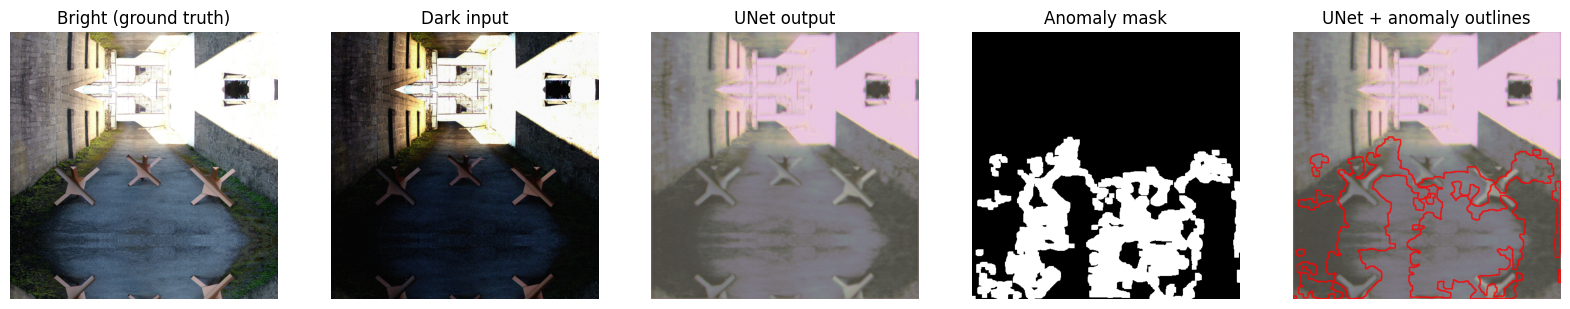

Example frame: RoadAnomaly_jpg/frames/obstacles06_cardboard_czech_hedgehog.jpg


In [23]:
#@title Run Cityscapes anomaly detection on a UNet example
if "model" not in globals():
    print("UNet model variable 'model' not found. Train it first (run the training cell).")
else:
    city_model = load_cityscapes_model()
    visualize_example_with_city_anomaly(model, city_model, cfg)


In [17]:
# Quick test: verify Cityscapes model loads (no UNet needed)
try:
    _city_test_model = load_cityscapes_model()
    print("✅ Cityscapes model ready for inference.")
except Exception as e:
    print("❌ Cityscapes model load failed:", e)

Loading Cityscapes model: deeplabv3plus_mobilenet
Model loaded on cuda
✅ Cityscapes model ready for inference.
